## YoloV5

In [1]:
# =========================================================
# Cell 0 — Disable W&B prompts + choose device (GPU if possible)
# =========================================================
import os, torch

os.environ["WANDB_MODE"] = "disabled"
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_SILENT"] = "true"

DEVICE = "0" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE, "| CUDA:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


DEVICE: 0 | CUDA: True
GPU: Tesla T4


In [2]:
# =========================================================
# Cell 1 — Paths (your tgz) + extraction
# =========================================================
import tarfile
from pathlib import Path

TGZ_PATH = "/kaggle/input/flower-dataset-102/102flowers.tgz"
RAW_DIR = Path("/kaggle/working/oxford102_raw")
RAW_DIR.mkdir(parents=True, exist_ok=True)

# Extract .tgz
with tarfile.open(TGZ_PATH, "r:gz") as tar:
    tar.extractall(RAW_DIR)

print("Extracted to:", RAW_DIR)
print("Top-level:", [p.name for p in RAW_DIR.iterdir()][:30])


/tmp/ipykernel_226/1355852723.py:13: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(RAW_DIR)


Extracted to: /kaggle/working/oxford102_raw
Top-level: ['jpg']


In [3]:
# =========================================================
# Cell 2 — Locate image folder (jpg/) robustly
# =========================================================
from pathlib import Path

def find_jpg_dir(base: Path) -> Path:
    # Common locations after extracting Oxford 102
    candidates = [
        base / "jpg",
        base / "102flowers" / "jpg",
        base
    ]
    for c in candidates:
        if c.exists() and any(c.glob("*.jpg")):
            return c

    # fallback: search
    for p in base.rglob("*"):
        if p.is_dir() and any(p.glob("*.jpg")):
            return p

    raise FileNotFoundError("Could not find a folder containing .jpg images.")

IMG_DIR = find_jpg_dir(RAW_DIR)
print("IMG_DIR:", IMG_DIR)
print("Num JPG:", len(list(IMG_DIR.glob("*.jpg"))))
print("Example files:", [p.name for p in sorted(IMG_DIR.glob("*.jpg"))[:5]])


IMG_DIR: /kaggle/working/oxford102_raw/jpg
Num JPG: 8189
Example files: ['image_00001.jpg', 'image_00002.jpg', 'image_00003.jpg', 'image_00004.jpg', 'image_00005.jpg']


In [4]:
# =========================================================
# Cell 3 — Find imagelabels.mat (and optionally setid.mat)
# =========================================================
import numpy as np
import scipy.io as sio
from pathlib import Path

INPUT_DIR = Path("/kaggle/input/flower-dataset-102")

mat_files = list(INPUT_DIR.rglob("*.mat")) + list(RAW_DIR.rglob("*.mat"))
print("Found .mat files:")
for m in mat_files:
    print(" -", m)

LABELS_MAT = None
SETID_MAT = None

for m in mat_files:
    name = m.name.lower()
    if "imagelabels" in name:
        LABELS_MAT = m
    if "setid" in name:
        SETID_MAT = m

if LABELS_MAT is None:
    raise FileNotFoundError("imagelabels.mat not found in dataset. Can't train without labels.")

print("LABELS_MAT:", LABELS_MAT)
print("SETID_MAT:", SETID_MAT, "(not required since we do random splits)")


Found .mat files:
 - /kaggle/input/flower-dataset-102/imagelabels.mat
LABELS_MAT: /kaggle/input/flower-dataset-102/imagelabels.mat
SETID_MAT: None (not required since we do random splits)


In [5]:
# =========================================================
# Cell 4 — Load labels from imagelabels.mat and build (path, class_id)
# Oxford 102 typically: image_00001.jpg ... image_08189.jpg, labels 1..102
# =========================================================
import numpy as np
import scipy.io as sio
from pathlib import Path

mat = sio.loadmat(str(LABELS_MAT))
print("MAT keys:", list(mat.keys()))

# Most common key is 'labels'
if "labels" in mat:
    labels = mat["labels"].squeeze()
else:
    # fallback: pick a big numeric array
    candidates = []
    for k, v in mat.items():
        if isinstance(v, np.ndarray) and v.size > 1000:
            candidates.append(v.squeeze())
    if not candidates:
        raise ValueError("Could not locate labels array inside the .mat file.")
    labels = candidates[0]

labels = labels.astype(int)
N = int(labels.shape[0])
print("Labels shape:", labels.shape, "min/max:", labels.min(), labels.max())

samples = []
missing = 0
for i in range(1, N + 1):
    fname = f"image_{i:05d}.jpg"
    fpath = IMG_DIR / fname
    if not fpath.exists():
        missing += 1
        continue
    y = int(labels[i - 1])  # 1..102
    samples.append((str(fpath), y))

print("Built samples:", len(samples), "| Missing files:", missing)
print("Example:", samples[0])


MAT keys: ['__header__', '__version__', '__globals__', 'labels']
Labels shape: (8189,) min/max: 1 102
Built samples: 8189 | Missing files: 0
Example: ('/kaggle/working/oxford102_raw/jpg/image_00001.jpg', 77)


In [6]:
# =========================================================
# Cell 5 — Create two random 50/25/25 splits WITHOUT test leakage
# Output structure per split:
#   splitX_seedY/trainval/train/class_001/*.jpg
#   splitX_seedY/trainval/val/class_001/*.jpg
#   splitX_seedY/test/val/class_001/*.jpg     (test isolated; stored under val/ so YOLO val.py can read)
# =========================================================
import random, shutil, os
from tqdm import tqdm
from pathlib import Path

OUT_BASE = Path("/kaggle/working/flowers_yolo_splits")
SEEDS = [42, 1337]

def _safe_symlink(src_path: str, dst_path: Path, uniq_tag: str):
    dst_path.parent.mkdir(parents=True, exist_ok=True)
    if dst_path.exists():
        dst_path = dst_path.with_name(f"{dst_path.stem}_{uniq_tag}{dst_path.suffix}")
    os.symlink(src_path, str(dst_path))

def make_split_folders(out_root: Path, seed: int):
    if out_root.exists():
        shutil.rmtree(out_root)
    (out_root / "trainval").mkdir(parents=True, exist_ok=True)
    (out_root / "test").mkdir(parents=True, exist_ok=True)

    rng = random.Random(seed)
    idx = list(range(len(samples)))
    rng.shuffle(idx)

    n = len(idx)
    n_train = int(0.50 * n)
    n_val   = int(0.25 * n)

    train_idx = idx[:n_train]
    val_idx   = idx[n_train:n_train + n_val]
    test_idx  = idx[n_train + n_val:]

    # class directories class_001..class_102
    for c in range(1, 103):
        cls = f"class_{c:03d}"
        (out_root / "trainval" / "train" / cls).mkdir(parents=True, exist_ok=True)
        (out_root / "trainval" / "val"   / cls).mkdir(parents=True, exist_ok=True)
        (out_root / "test"     / "val"   / cls).mkdir(parents=True, exist_ok=True)

    for j in tqdm(train_idx, desc=f"Linking TRAIN seed={seed}"):
        src, y = samples[j]
        cls = f"class_{y:03d}"
        _safe_symlink(src, out_root / "trainval" / "train" / cls / Path(src).name, f"tr{j}")

    for j in tqdm(val_idx, desc=f"Linking VAL seed={seed}"):
        src, y = samples[j]
        cls = f"class_{y:03d}"
        _safe_symlink(src, out_root / "trainval" / "val" / cls / Path(src).name, f"va{j}")

    for j in tqdm(test_idx, desc=f"Linking TEST seed={seed}"):
        src, y = samples[j]
        cls = f"class_{y:03d}"
        _safe_symlink(src, out_root / "test" / "val" / cls / Path(src).name, f"te{j}")

    print(f"\n✅ Done: {out_root}")
    print("Sizes:", {"train": len(train_idx), "val": len(val_idx), "test": len(test_idx)})

OUT_BASE.mkdir(parents=True, exist_ok=True)

split_roots = []
for k, seed in enumerate(SEEDS, start=1):
    out_root = OUT_BASE / f"split{k}_seed{seed}"
    make_split_folders(out_root, seed)
    split_roots.append(out_root)

split_roots


Linking TEST seed=42: 100%|██████████| 2048/2048 [00:00<00:00, 19896.87it/s]



✅ Done: /kaggle/working/flowers_yolo_splits/split1_seed42
Sizes: {'train': 4094, 'val': 2047, 'test': 2048}


Linking TEST seed=1337: 100%|██████████| 2048/2048 [00:00<00:00, 20481.00it/s]


✅ Done: /kaggle/working/flowers_yolo_splits/split2_seed1337
Sizes: {'train': 4094, 'val': 2047, 'test': 2048}


[PosixPath('/kaggle/working/flowers_yolo_splits/split1_seed42'),
 PosixPath('/kaggle/working/flowers_yolo_splits/split2_seed1337')]

In [7]:
# =========================================================
# Cell 6 — Sanity check counts (optional but helpful)
# =========================================================
from pathlib import Path

def count_jpg(p: Path) -> int:
    return len(list(p.rglob("*.jpg")))

for r in split_roots:
    print("\n==", r.name, "==")
    print("train:", count_jpg(r / "trainval" / "train"))
    print("val:  ", count_jpg(r / "trainval" / "val"))
    print("test: ", count_jpg(r / "test" / "val"))



== split1_seed42 ==
train: 4094
val:   2047
test:  2048

== split2_seed1337 ==
train: 4094
val:   2047
test:  2048


In [8]:
# =========================================================
# Cell 7 — Clone/setup YOLOv5
# =========================================================
import os

%cd /kaggle/working

if not os.path.exists("/kaggle/working/yolov5"):
    !git clone https://github.com/ultralytics/yolov5

%cd /kaggle/working/yolov5
!pip -q install -r requirements.txt


/kaggle/working
/kaggle/working/yolov5


In [9]:
#!pip -q uninstall -y wandb


In [10]:
# Cell 8 — Train split1 (fixed)
SPLIT1_ROOT = split_roots[0]
TRAINVAL1 = str(SPLIT1_ROOT / "trainval")   # has train/ and val/
TEST1     = str(SPLIT1_ROOT / "test")       # has val/ only

PROJECT1 = "flowers_split1"   # <-- simple name, no paths
NAME1    = "yolov5s_cls"

!python classify/train.py \
  --model yolov5s-cls.pt \
  --data {TRAINVAL1} \
  --imgsz 224 \
  --batch-size 64 \
  --epochs 20 \
  --device {DEVICE} \
  --project {PROJECT1} \
  --name {NAME1} \
  --exist-ok


2026-02-01 11:19:30.079407: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769944770.100304     275 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769944770.106816     275 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769944770.124300     275 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769944770.124328     275 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769944770.124331     275 computation_placer.cc:177] computation placer alr

In [11]:
# Cell 9 — Verify weights exist
import os

RUN_DIR1 = f"runs/train-cls/{PROJECT1}/{NAME1}"
WEIGHTS1 = f"{RUN_DIR1}/weights"
print("Run dir:", RUN_DIR1)
print("Weights dir exists:", os.path.exists(WEIGHTS1))
if os.path.exists(WEIGHTS1):
    print("Weights:", os.listdir(WEIGHTS1))

BEST1 = f"{WEIGHTS1}/best.pt"
print("BEST1 exists?", os.path.exists(BEST1), "|", BEST1)


Run dir: runs/train-cls/flowers_split1/yolov5s_cls
Weights dir exists: False
BEST1 exists? False | runs/train-cls/flowers_split1/yolov5s_cls/weights/best.pt


In [13]:
%cd /kaggle/working/yolov5
!pwd
!ls -la
!ls -la runs || echo "No runs/ folder here"
!find runs -maxdepth 3 -type d -print 2>/dev/null | head -n 50


/kaggle/working/yolov5
/kaggle/working/yolov5
total 11248
drwxr-xr-x 12 root root     4096 Feb  1 11:22 .
drwxr-xr-x  7 root root     4096 Feb  1 11:16 ..
-rw-r--r--  1 root root    14130 Feb  1 11:15 benchmarks.py
-rw-r--r--  1 root root      393 Feb  1 11:15 CITATION.cff
drwxr-xr-x  3 root root     4096 Feb  1 11:15 classify
-rw-r--r--  1 root root     5419 Feb  1 11:15 CONTRIBUTING.md
drwxr-xr-x  5 root root     4096 Feb  1 11:15 data
-rw-r--r--  1 root root    23760 Feb  1 11:15 detect.py
-rw-r--r--  1 root root     3701 Feb  1 11:15 .dockerignore
-rw-r--r--  1 root root    68529 Feb  1 11:15 export.py
drwxr-xr-x  3 root root     4096 Feb  1 11:19 flowers_split1
drwxr-xr-x  8 root root     4096 Feb  1 11:16 .git
-rw-r--r--  1 root root       75 Feb  1 11:15 .gitattributes
drwxr-xr-x  4 root root     4096 Feb  1 11:15 .github
-rwxr-xr-x  1 root root     4010 Feb  1 11:15 .gitignore
-rw-r--r--  1 root root    24051 Feb  1 11:15 hubconf.py
-rw-r--r--  1 root root    34523 Feb  1 11:15

In [14]:
!find /kaggle/working -type f -name "best.pt" -o -name "last.pt" | head -n 50


/kaggle/working/yolov5/flowers_split1/yolov5s_cls/weights/best.pt
/kaggle/working/yolov5/flowers_split1/yolov5s_cls/weights/last.pt


In [15]:
BEST1 = "/kaggle/working/yolov5/flowers_split1/yolov5s_cls/weights/best.pt"

In [16]:
print("== Split1: VAL ==")
!python classify/val.py --weights {BEST1} --data {TRAINVAL1} --img 224 --device {DEVICE}

print("\n== Split1: TEST ==")
!python classify/val.py --weights {BEST1} --data {TEST1} --img 224 --device {DEVICE}


== Split1: VAL ==
classify/val: data=/kaggle/working/flowers_yolo_splits/split1_seed42/trainval, weights=['/kaggle/working/yolov5/flowers_split1/yolov5s_cls/weights/best.pt'], batch_size=128, imgsz=224, device=0, workers=8, verbose=True, project=runs/val-cls, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-457-g84ef1e59 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 14913MiB)

Fusing layers... 
Model summary: 117 layers, 4297350 parameters, 0 gradients, 10.5 GFLOPs
validating:   0%|          | 0/16 [00:00<?, ?it/s]/kaggle/working/yolov5/classify/val.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type != "cpu"):
validating: 100%|██████████| 16/16 [00:03<00:00,  4.26it/s]
                   Class      Images    top1_acc    top5_acc
                     all        2047       0.979       0.996
               class_001          12           1   

In [17]:
# =========================================================
# Cell 11 — Train YOLOv5-CLS on split2
# =========================================================
SPLIT2_ROOT = split_roots[1]                 # split2_seed1337
TRAINVAL2 = str(SPLIT2_ROOT / "trainval")    # contains train/ + val/
TEST2     = str(SPLIT2_ROOT / "test")        # contains val/ only (our isolated test)

PROJECT2 = "flowers_split2"                  # IMPORTANT: no slashes
NAME2    = "yolov5s_cls"                     # run name

print("TRAINVAL2:", TRAINVAL2)
print("TEST2:", TEST2)

!python classify/train.py \
  --model yolov5s-cls.pt \
  --data {TRAINVAL2} \
  --imgsz 224 \
  --batch-size 64 \
  --epochs 20 \
  --device {DEVICE} \
  --project {PROJECT2} \
  --name {NAME2} \
  --exist-ok


TRAINVAL2: /kaggle/working/flowers_yolo_splits/split2_seed1337/trainval
TEST2: /kaggle/working/flowers_yolo_splits/split2_seed1337/test
2026-02-01 11:30:34.150242: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769945434.171945     478 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769945434.178463     478 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769945434.195190     478 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769945434.195218     478 computation_placer.cc:177] computation placer already registered. Please check linkage a

In [18]:
# =========================================================
# Cell 12 — Verify weights exist (split2)
# =========================================================
RUN_DIR2 = f"runs/train-cls/{PROJECT2}/{NAME2}"
WEIGHTS2 = f"{RUN_DIR2}/weights"
print("Run dir:", RUN_DIR2)
print("Weights dir exists:", os.path.exists(WEIGHTS2))
if os.path.exists(WEIGHTS2):
    print("Weights:", os.listdir(WEIGHTS2))

BEST2 = f"{WEIGHTS2}/best.pt"
LAST2 = f"{WEIGHTS2}/last.pt"
print("BEST2 exists?", os.path.exists(BEST2), "|", BEST2)
print("LAST2 exists?", os.path.exists(LAST2), "|", LAST2)


Run dir: runs/train-cls/flowers_split2/yolov5s_cls
Weights dir exists: False
BEST2 exists? False | runs/train-cls/flowers_split2/yolov5s_cls/weights/best.pt
LAST2 exists? False | runs/train-cls/flowers_split2/yolov5s_cls/weights/last.pt


In [19]:
BEST2 = "/kaggle/working/yolov5/flowers_split1/yolov5s_cls/weights/best.pt"

In [20]:
# =========================================================
# Cell 13 — Evaluate split2 on VAL and TEST
# =========================================================
print("== Split2: VAL ==")
!python classify/val.py --weights {BEST2} --data {TRAINVAL2} --img 224 --device {DEVICE}

print("\n== Split2: TEST ==")
!python classify/val.py --weights {BEST2} --data {TEST2} --img 224 --device {DEVICE}


== Split2: VAL ==
classify/val: data=/kaggle/working/flowers_yolo_splits/split2_seed1337/trainval, weights=['/kaggle/working/yolov5/flowers_split1/yolov5s_cls/weights/best.pt'], batch_size=128, imgsz=224, device=0, workers=8, verbose=True, project=runs/val-cls, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-457-g84ef1e59 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 14913MiB)

Fusing layers... 
Model summary: 117 layers, 4297350 parameters, 0 gradients, 10.5 GFLOPs
validating:   0%|          | 0/16 [00:00<?, ?it/s]/kaggle/working/yolov5/classify/val.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type != "cpu"):
validating: 100%|██████████| 16/16 [00:03<00:00,  4.41it/s]
                   Class      Images    top1_acc    top5_acc
                     all        2047        0.99           1
               class_001           9           1 

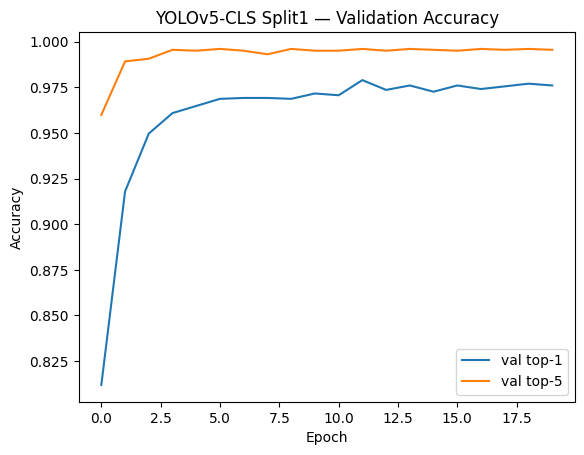

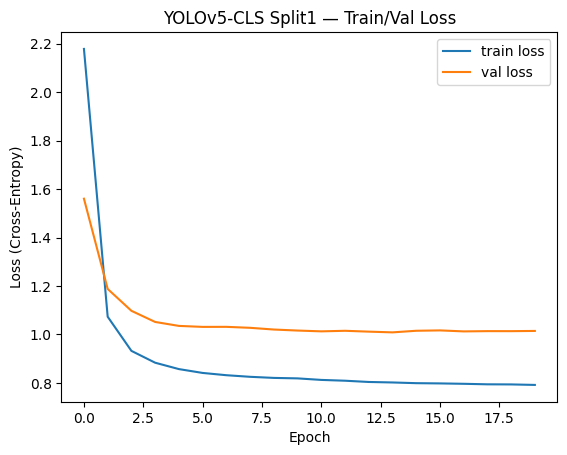

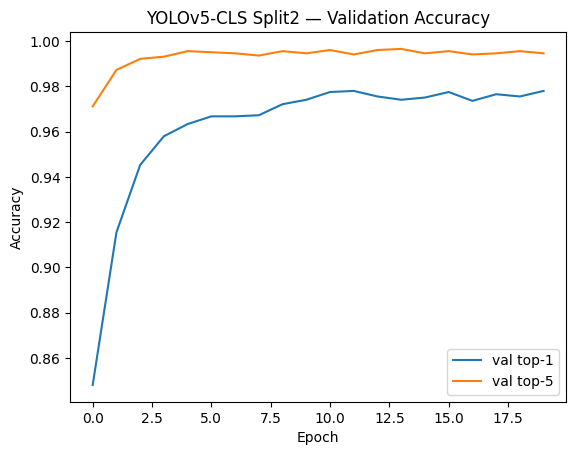

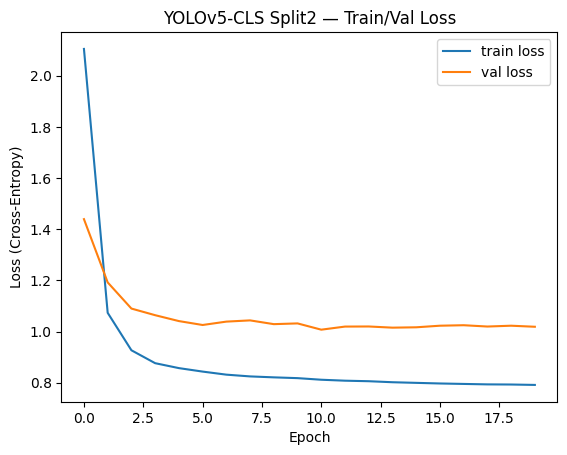

In [22]:
# =========================================================
# Cell 14 — Plot YOLOv5 results.csv (accuracy + cross-entropy vs epochs)
# This produces the curves you need for YOLO.
# =========================================================
import pandas as pd
import matplotlib.pyplot as plt

def plot_yolo_results(results_csv_path, title=""):
    df = pd.read_csv(results_csv_path)
    df.columns = df.columns.str.strip()

    # Typical columns: epoch, train/loss, val/loss, metrics/accuracy_top1, metrics/accuracy_top5
    if "epoch" in df.columns:
        epoch = df["epoch"]
    else:
        epoch = range(len(df))

    # Accuracy plot
    plt.figure()
    if "metrics/accuracy_top1" in df.columns:
        plt.plot(epoch, df["metrics/accuracy_top1"], label="val top-1")
    if "metrics/accuracy_top5" in df.columns:
        plt.plot(epoch, df["metrics/accuracy_top5"], label="val top-5")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{title} — Validation Accuracy")
    plt.legend()
    plt.show()

    # Loss plot (cross entropy)
    plt.figure()
    if "train/loss" in df.columns:
        plt.plot(epoch, df["train/loss"], label="train loss")
    if "val/loss" in df.columns:
        plt.plot(epoch, df["val/loss"], label="val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (Cross-Entropy)")
    plt.title(f"{title} — Train/Val Loss")
    plt.legend()
    plt.show()

RESULTS1 = f"/kaggle/working/yolov5/flowers_split1/yolov5s_cls/results.csv"
RESULTS2 = f"/kaggle/working/yolov5/flowers_split2/yolov5s_cls/results.csv"

plot_yolo_results(RESULTS1, "YOLOv5-CLS Split1")
plot_yolo_results(RESULTS2, "YOLOv5-CLS Split2")


## VGG 19

In [23]:
# =========================================================
# Cell 0 — Imports + device
# =========================================================
import os, random
from pathlib import Path
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device, "| CUDA:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


Device: cuda | CUDA: True
GPU: Tesla T4


In [24]:
# =========================================================
# Cell 1 — Point to the SAME split folders you made for YOLO
# Expected structure per split:
#  /kaggle/working/flowers_yolo_splits/splitX_seedYYY/trainval/train/class_001/...
#  /kaggle/working/flowers_yolo_splits/splitX_seedYYY/trainval/val/class_001/...
#  /kaggle/working/flowers_yolo_splits/splitX_seedYYY/test/val/class_001/...   (isolated test)
# =========================================================
SPLITS_BASE = Path("/kaggle/working/flowers_yolo_splits")

SPLIT1_ROOT = SPLITS_BASE / "split1_seed42"
SPLIT2_ROOT = SPLITS_BASE / "split2_seed1337"

def split_paths(split_root: Path):
    train_dir = split_root / "trainval" / "train"
    val_dir   = split_root / "trainval" / "val"
    test_dir  = split_root / "test" / "val"   # note: we stored test under val/ for convenience
    return train_dir, val_dir, test_dir

train1, val1, test1 = split_paths(SPLIT1_ROOT)
train2, val2, test2 = split_paths(SPLIT2_ROOT)

print("Split1:", train1, val1, test1)
print("Split2:", train2, val2, test2)
print("Split1 exists?", train1.exists(), val1.exists(), test1.exists())
print("Split2 exists?", train2.exists(), val2.exists(), test2.exists())


Split1: /kaggle/working/flowers_yolo_splits/split1_seed42/trainval/train /kaggle/working/flowers_yolo_splits/split1_seed42/trainval/val /kaggle/working/flowers_yolo_splits/split1_seed42/test/val
Split2: /kaggle/working/flowers_yolo_splits/split2_seed1337/trainval/train /kaggle/working/flowers_yolo_splits/split2_seed1337/trainval/val /kaggle/working/flowers_yolo_splits/split2_seed1337/test/val
Split1 exists? True True True
Split2 exists? True True True


In [25]:
# =========================================================
# Cell 2 — Transforms (preprocessing)
# Train uses augmentation; val/test use deterministic preprocessing
# =========================================================
IM_SIZE = 224

train_tf = transforms.Compose([
    transforms.RandomResizedCrop(IM_SIZE, scale=(0.75, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.10, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

eval_tf = transforms.Compose([
    transforms.Resize((IM_SIZE, IM_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


In [26]:
# =========================================================
# Cell 3 — Datasets + loaders helper
# =========================================================
def make_loaders(train_dir, val_dir, test_dir, batch_size=32, num_workers=2):
    train_ds = datasets.ImageFolder(str(train_dir), transform=train_tf)
    val_ds   = datasets.ImageFolder(str(val_dir),   transform=eval_tf)
    test_ds  = datasets.ImageFolder(str(test_dir),  transform=eval_tf)

    # Ensure consistent class mapping across splits
    assert train_ds.class_to_idx == val_ds.class_to_idx == test_ds.class_to_idx, "Class mapping mismatch!"

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                              num_workers=num_workers, pin_memory=torch.cuda.is_available())
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                              num_workers=num_workers, pin_memory=torch.cuda.is_available())
    test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False,
                              num_workers=num_workers, pin_memory=torch.cuda.is_available())
    return train_ds, val_ds, test_ds, train_loader, val_loader, test_loader

# Build split1 loaders
train_ds1, val_ds1, test_ds1, train_loader1, val_loader1, test_loader1 = make_loaders(train1, val1, test1)

num_classes = len(train_ds1.classes)
print("Num classes:", num_classes)
print("Example class names:", train_ds1.classes[:5])


Num classes: 102
Example class names: ['class_001', 'class_002', 'class_003', 'class_004', 'class_005']


In [27]:
# =========================================================
# Cell 4 — Model builder (VGG19 transfer learning)
# - Freeze feature extractor
# - Replace classifier head for 102 classes
# =========================================================
def build_vgg19(num_classes: int, freeze_features: bool = True):
    weights = models.VGG19_Weights.IMAGENET1K_V1
    model = models.vgg19(weights=weights)

    if freeze_features:
        for p in model.features.parameters():
            p.requires_grad = False

    # Replace last layer of classifier
    in_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(in_features, num_classes)

    return model

model = build_vgg19(num_classes=num_classes, freeze_features=True).to(device)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:02<00:00, 216MB/s] 


In [28]:
# =========================================================
# Cell 5 — Train/eval utilities (loss + accuracy)
# =========================================================
def accuracy_top1(logits, y):
    preds = logits.argmax(dim=1)
    return (preds == y).float().mean().item()

@torch.no_grad()
def run_eval_epoch(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total = 0

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        out = model(x)
        loss = criterion(out, y)

        total_loss += loss.item() * x.size(0)
        total_correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)

    return total_loss / total, total_correct / total

def run_train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total = 0

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        total_correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)

    return total_loss / total, total_correct / total


In [29]:
# =========================================================
# Cell 6 — Training loop (logs TRAIN/VAL/TEST per epoch)
# This satisfies: accuracy + cross-entropy for train/val/test vs epochs
# =========================================================
def train_vgg(
    train_loader, val_loader, test_loader,
    num_classes: int,
    epochs: int = 15,
    lr: float = 1e-4,
    weight_decay: float = 1e-4,
    freeze_features: bool = True,
    unfreeze_last_block_epoch: int | None = 8,   # optional fine-tune
    finetune_lr: float = 1e-5
):
    model = build_vgg19(num_classes=num_classes, freeze_features=freeze_features).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW([p for p in model.parameters() if p.requires_grad],
                                  lr=lr, weight_decay=weight_decay)

    history = {
        "train_loss": [], "train_acc": [],
        "val_loss":   [], "val_acc":   [],
        "test_loss":  [], "test_acc":  [],
    }

    best_val = -1.0
    best_state = None

    for epoch in range(1, epochs + 1):
        # Optional: unfreeze last conv block for fine-tuning
        if unfreeze_last_block_epoch is not None and epoch == unfreeze_last_block_epoch:
            # In VGG19, features are a Sequential; unfreeze last ~8 layers (last block)
            for p in model.features.parameters():
                p.requires_grad = False
            for layer in list(model.features.children())[-8:]:
                for p in layer.parameters():
                    p.requires_grad = True

            # Recreate optimizer with smaller LR for fine-tuning
            optimizer = torch.optim.AdamW([p for p in model.parameters() if p.requires_grad],
                                          lr=finetune_lr, weight_decay=weight_decay)
            print(f"🔓 Unfroze last VGG block at epoch {epoch}, switched LR to {finetune_lr}")

        tr_loss, tr_acc = run_train_epoch(model, train_loader, criterion, optimizer)
        va_loss, va_acc = run_eval_epoch(model, val_loader, criterion)
        te_loss, te_acc = run_eval_epoch(model, test_loader, criterion)

        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_loss"].append(va_loss)
        history["val_acc"].append(va_acc)
        history["test_loss"].append(te_loss)
        history["test_acc"].append(te_acc)

        if va_acc > best_val:
            best_val = va_acc
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

        print(f"Epoch {epoch:02d}/{epochs} | "
              f"Train: {tr_acc:.3f} loss {tr_loss:.3f} | "
              f"Val: {va_acc:.3f} loss {va_loss:.3f} | "
              f"Test: {te_acc:.3f} loss {te_loss:.3f}")

    # Load best val checkpoint
    if best_state is not None:
        model.load_state_dict(best_state)

    return model, history

EPOCHS = 15
model1, hist1 = train_vgg(train_loader1, val_loader1, test_loader1, num_classes=num_classes, epochs=EPOCHS)


Epoch 01/15 | Train: 0.360 loss 2.801 | Val: 0.683 loss 1.297 | Test: 0.693 loss 1.274
Epoch 02/15 | Train: 0.725 loss 1.014 | Val: 0.800 loss 0.756 | Test: 0.811 loss 0.752
Epoch 03/15 | Train: 0.836 loss 0.574 | Val: 0.829 loss 0.623 | Test: 0.836 loss 0.604
Epoch 04/15 | Train: 0.891 loss 0.376 | Val: 0.844 loss 0.570 | Test: 0.843 loss 0.562
Epoch 05/15 | Train: 0.926 loss 0.253 | Val: 0.853 loss 0.526 | Test: 0.859 loss 0.521
Epoch 06/15 | Train: 0.947 loss 0.184 | Val: 0.854 loss 0.549 | Test: 0.853 loss 0.531
Epoch 07/15 | Train: 0.961 loss 0.130 | Val: 0.861 loss 0.510 | Test: 0.877 loss 0.463
🔓 Unfroze last VGG block at epoch 8, switched LR to 1e-05
Epoch 08/15 | Train: 0.985 loss 0.056 | Val: 0.895 loss 0.432 | Test: 0.908 loss 0.387
Epoch 09/15 | Train: 0.989 loss 0.037 | Val: 0.894 loss 0.446 | Test: 0.902 loss 0.408
Epoch 10/15 | Train: 0.992 loss 0.031 | Val: 0.902 loss 0.414 | Test: 0.911 loss 0.380
Epoch 11/15 | Train: 0.988 loss 0.032 | Val: 0.905 loss 0.407 | Test: 0.

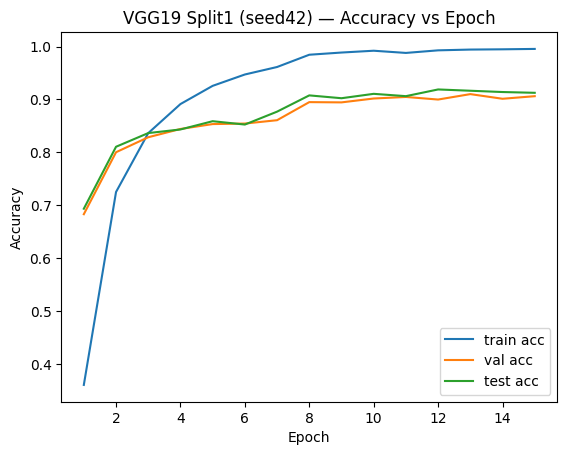

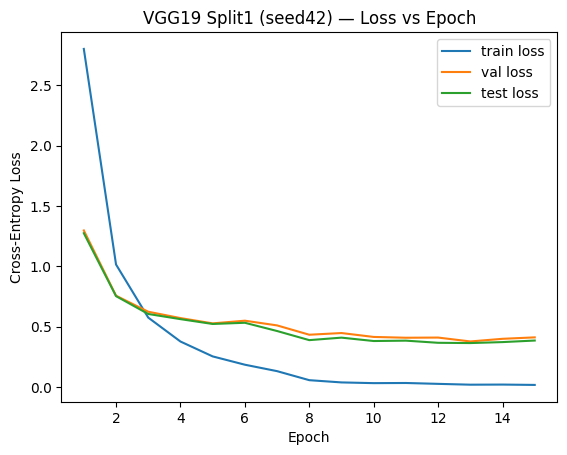

In [30]:
# =========================================================
# Cell 7 — Plot curves (TRAIN/VAL/TEST) for Split1
# =========================================================
def plot_history(history, title_prefix="VGG19"):
    epochs = range(1, len(history["train_loss"]) + 1)

    # Accuracy
    plt.figure()
    plt.plot(epochs, history["train_acc"], label="train acc")
    plt.plot(epochs, history["val_acc"], label="val acc")
    plt.plot(epochs, history["test_acc"], label="test acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy")
    plt.title(f"{title_prefix} — Accuracy vs Epoch")
    plt.legend(); plt.show()

    # Loss (cross-entropy)
    plt.figure()
    plt.plot(epochs, history["train_loss"], label="train loss")
    plt.plot(epochs, history["val_loss"], label="val loss")
    plt.plot(epochs, history["test_loss"], label="test loss")
    plt.xlabel("Epoch"); plt.ylabel("Cross-Entropy Loss")
    plt.title(f"{title_prefix} — Loss vs Epoch")
    plt.legend(); plt.show()

plot_history(hist1, title_prefix="VGG19 Split1 (seed42)")


Epoch 01/15 | Train: 0.364 loss 2.774 | Val: 0.679 loss 1.268 | Test: 0.713 loss 1.193
Epoch 02/15 | Train: 0.733 loss 0.986 | Val: 0.777 loss 0.849 | Test: 0.806 loss 0.758
Epoch 03/15 | Train: 0.848 loss 0.528 | Val: 0.815 loss 0.663 | Test: 0.835 loss 0.601
Epoch 04/15 | Train: 0.899 loss 0.360 | Val: 0.826 loss 0.600 | Test: 0.842 loss 0.556
Epoch 05/15 | Train: 0.933 loss 0.231 | Val: 0.834 loss 0.587 | Test: 0.853 loss 0.526
Epoch 06/15 | Train: 0.952 loss 0.167 | Val: 0.839 loss 0.568 | Test: 0.858 loss 0.523
Epoch 07/15 | Train: 0.962 loss 0.130 | Val: 0.839 loss 0.558 | Test: 0.858 loss 0.541
🔓 Unfroze last VGG block at epoch 8, switched LR to 1e-05
Epoch 08/15 | Train: 0.981 loss 0.063 | Val: 0.877 loss 0.440 | Test: 0.891 loss 0.401
Epoch 09/15 | Train: 0.984 loss 0.051 | Val: 0.881 loss 0.446 | Test: 0.900 loss 0.390
Epoch 10/15 | Train: 0.992 loss 0.030 | Val: 0.889 loss 0.420 | Test: 0.908 loss 0.387
Epoch 11/15 | Train: 0.992 loss 0.029 | Val: 0.884 loss 0.436 | Test: 0.

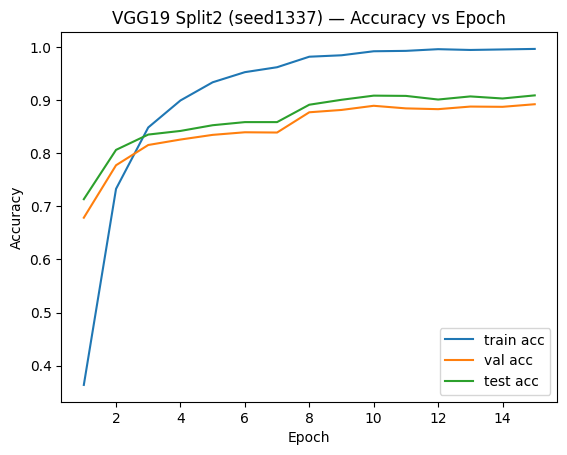

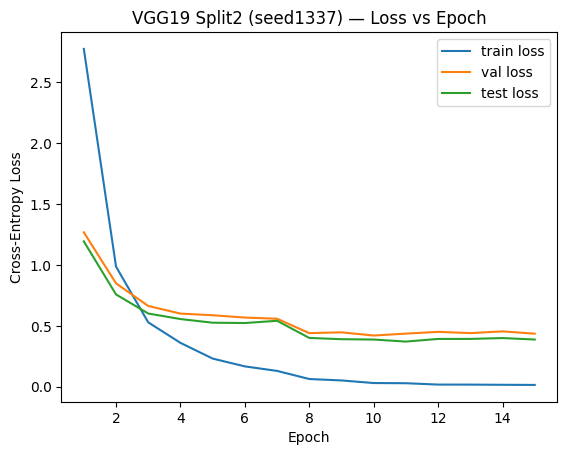

In [31]:
# =========================================================
# Cell 8 — Run the SAME VGG19 training on Split2 (required)
# =========================================================
# Build split2 loaders (fresh datasets/mapping check)
train_ds2, val_ds2, test_ds2, train_loader2, val_loader2, test_loader2 = make_loaders(train2, val2, test2)

# Sanity: class mapping should match split1
assert train_ds1.class_to_idx == train_ds2.class_to_idx, "Split1 vs Split2 class_to_idx mismatch!"

model2, hist2 = train_vgg(train_loader2, val_loader2, test_loader2, num_classes=num_classes, epochs=EPOCHS)
plot_history(hist2, title_prefix="VGG19 Split2 (seed1337)")


In [32]:
# =========================================================
# Cell 9 — Summary across splits (mean ± std of final test acc)
# Helpful for your report
# =========================================================
import numpy as np
final_test_acc_1 = hist1["test_acc"][-1]
final_test_acc_2 = hist2["test_acc"][-1]

mean = np.mean([final_test_acc_1, final_test_acc_2])
std  = np.std([final_test_acc_1, final_test_acc_2], ddof=1)

print("Final Test Acc:")
print(" Split1:", final_test_acc_1)
print(" Split2:", final_test_acc_2)
print(f" Mean ± std: {mean:.4f} ± {std:.4f}")


Final Test Acc:
 Split1: 0.91259765625
 Split2: 0.90869140625
 Mean ± std: 0.9106 ± 0.0028
